## Augmentation
---



augmentation 효과를 확실하게 보기 위해 여러가지 시도를 해 보았는데, 그 중 가장 결과가 좋았던 두번째 시도의 코드를 기준으로 작성했다

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import urllib3
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
# import imgaug.augmenters as iaa

### 1. Dataset with Augmentation


---



- standford_dogs 데이터 사용 

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteKVMWJM/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteKVMWJM/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [ ]:
ds_info.features["label"].names[:10]

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound']

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

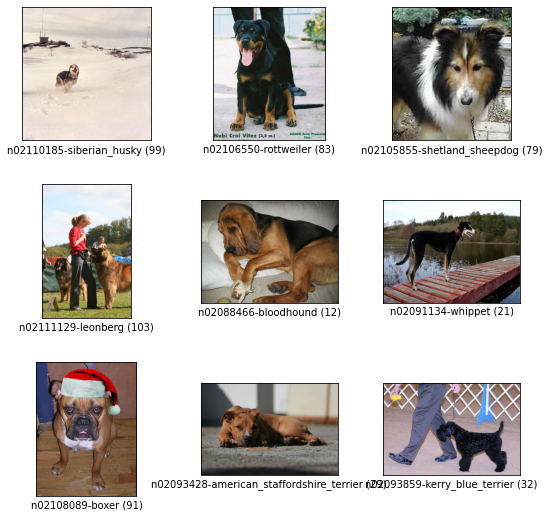

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)

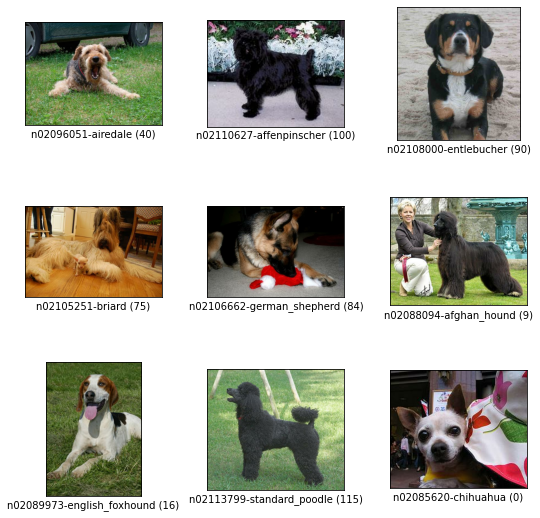

In [ ]:
fig = tfds.show_examples(ds_test, ds_info)

1. augmentation 전에 data 를 전처리 하는 함수 
- image 를 원하는 사이즈로 resize 하고 normalize 해주는 함수

In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

- 기본 augmentation 적용 함수 
  - random 하게 좌우 반전을 주어 데이터를 늘려준다
  - random 하게 밝기를 조절해준다

In [ ]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    # image = tf.clip_by_value(image,0.1)
    return image,label

### 2. CutMix augmentation


---



- 이미지 데이터를 자르고 섞는다
- Cutout 으로 이미지를 자르고 자른 이미지를 mix 하는 것 
- 이미지를 섞는 부분과 섞은 이미지에 맞추어 라벨도 섞어줘야함 

1. 두가지 이미지중 바탕 이미지 A 에 삽일될 영역의 바운딩 박스 위치를 결정하는 함수

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

2. 바탕 이미지에서 바운딩 박스 바깥쪽 영역을 다른이미지에서 바운딩 박스 안쪽 영역을 가져와 합치는 함수

In [ ]:
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img


3. 이미지를 섞은 비율에 맞게 라벨도 섞어주는 함수 

In [ ]:
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, image_size=224,num_classes=120):
    # image_size_x = image_a.shape[1]
    # image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size*image_size
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

4. 배치단위의 cutmix 함수

In [ ]:
def cutmix(image, label, prob = 1.0, batch_size=32, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_labels(label_a, label_b, xa, ya, xb, yb))
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 3. Mixup Augmentation


---



- 두가지 이미지와 라벨을 블렌딩 해준다 
- 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식
- 두 이미지 쌍을 섞은 비율을 일정 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어준다

In [ ]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [ ]:
def mixup(image, label, prob = 1.0, batch_size=32, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 4. Onehot 

---



- cutmix 와 mixup 을 사용할 경우 test 이미지에 onehot 을 적용하여 비교하여야 한다

In [ ]:
def onehot(image, label, prob = 1.0, batch_size=32, img_size=224, num_classes=120):
    onehot_imgs = []
    onehot_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        if len(label_a.shape)==0:
            label_a = tf.one_hot(label_a, num_classes)
        
        onehot_imgs.append(image_a)
        onehot_labels.append(label_a)

    onehot_imgs = tf.reshape(tf.stack(onehot_imgs),(batch_size, img_size, img_size, 3))
    onehot_labels = tf.reshape(tf.stack(onehot_labels),(batch_size, num_classes))
    return onehot_imgs, onehot_labels

### 5. Apply augmentation on dataset 

---



In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=32, 
                               with_img=False, with_aug=False, 
                               with_cutmix=False, with_mixup=False,
                               one_hot=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    if not is_test and with_mixup:
        ds = ds.map(
            mixup, 
            num_parallel_calls=2
        )
    if is_test and one_hot:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 6. Model Load


---


- keras 에 들어있는 resnet 50 을 가져와서 사용

In [ ]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [ ]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train,with_aug=True, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train,with_aug=True, with_mixup=True)
ds_test_no = apply_normalize_on_dataset(ds_test, is_test = True)
ds_test_one = apply_normalize_on_dataset(ds_test, one_hot=True, is_test = True)

In [ ]:
print(ds_train_no_aug)
print(ds_train_aug)
print(ds_test_no)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:
print(ds_train_cutmix)
print(ds_train_mixup)
print(ds_test_one)

<PrefetchDataset element_spec=(TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 120), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 120), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 120), dtype=tf.float32, name=None))>


In [ ]:
print(ds_train_cutmix)

<PrefetchDataset element_spec=(TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 120), dtype=tf.float32, name=None))>


### 7. Train

---



In [ ]:
tf.random.set_seed(2022)
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/32),
    validation_steps=int(ds_info.splits['test'].num_examples/32),
    epochs=15,
    validation_data=ds_test_no,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
375/375 [==============================] - 98s 204ms/step - loss: 2.5101 - accuracy: 0.4260 - val_loss: 5.0974 - val_accuracy: 0.0096
Epoch 2/15
375/375 [==============================] - 75s 201ms/step - loss: 0.8685 - accuracy: 0.7744 - val_loss: 3.0049 - val_accuracy: 0.2726
Epoch 3/15
375/375 [==============================] - 75s 201ms/step - loss: 0.4016 - accuracy: 0.9100 - val_loss: 1.0557 - val_accuracy: 0.6917
Epoch 4/15
375/375 [==============================] - 75s 201ms/step - loss: 0.1660 - accuracy: 0.9772 - val_loss: 0.9319 - val_accuracy: 0.7212
Epoch 5/15
375/375 [==============================] - 75s 200ms/step - loss: 0.0689 - accuracy: 0.9958 - val_loss: 0.9078 - val_accuracy: 0.7315
Epoch 6/15
375/375 [==============================] - 75s 201ms/step - loss: 0.0419 - accuracy: 0.9986 - val_loss: 0.9257 - val_accuracy: 0.7311
Epoch 7/15
375/375 [==============================] - 75s 201ms/step - loss: 0.0408 - accuracy: 0.9987 - val_loss: 0.9228 - val_ac

In [ ]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/32),
    validation_steps=int(ds_info.splits['test'].num_examples/32),
    epochs=15,
    validation_data=ds_test_no,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
375/375 [==============================] - 86s 202ms/step - loss: 2.5580 - accuracy: 0.4119 - val_loss: 4.9475 - val_accuracy: 0.0069
Epoch 2/15
375/375 [==============================] - 75s 200ms/step - loss: 0.9959 - accuracy: 0.7254 - val_loss: 3.0029 - val_accuracy: 0.2744
Epoch 3/15
375/375 [==============================] - 75s 200ms/step - loss: 0.6114 - accuracy: 0.8378 - val_loss: 1.1019 - val_accuracy: 0.6769
Epoch 4/15
375/375 [==============================] - 75s 200ms/step - loss: 0.3799 - accuracy: 0.9097 - val_loss: 0.9939 - val_accuracy: 0.7014
Epoch 5/15
375/375 [==============================] - 82s 218ms/step - loss: 0.2223 - accuracy: 0.9544 - val_loss: 0.8984 - val_accuracy: 0.7317
Epoch 6/15
375/375 [==============================] - 76s 202ms/step - loss: 0.1391 - accuracy: 0.9774 - val_loss: 0.8839 - val_accuracy: 0.7399
Epoch 7/15
375/375 [==============================] - 76s 202ms/step - loss: 0.0866 - accuracy: 0.9885 - val_loss: 0.9063 - val_ac

In [ ]:
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/32),
    validation_steps=int(ds_info.splits['test'].num_examples/32),
    epochs=15,
    validation_data=ds_test_one,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
375/375 [==============================] - 99s 224ms/step - loss: 4.1133 - accuracy: 0.1589 - val_loss: 5.0746 - val_accuracy: 0.0133
Epoch 2/15
375/375 [==============================] - 77s 206ms/step - loss: 3.1270 - accuracy: 0.3868 - val_loss: 2.5680 - val_accuracy: 0.3521
Epoch 3/15
375/375 [==============================] - 83s 221ms/step - loss: 2.8175 - accuracy: 0.4693 - val_loss: 1.3930 - val_accuracy: 0.6335
Epoch 4/15
375/375 [==============================] - 77s 206ms/step - loss: 2.6353 - accuracy: 0.5281 - val_loss: 1.2010 - val_accuracy: 0.6768
Epoch 5/15
375/375 [==============================] - 77s 206ms/step - loss: 2.5207 - accuracy: 0.5596 - val_loss: 1.1730 - val_accuracy: 0.6835
Epoch 6/15
375/375 [==============================] - 77s 205ms/step - loss: 2.4254 - accuracy: 0.5911 - val_loss: 1.1091 - val_accuracy: 0.6936
Epoch 7/15
375/375 [==============================] - 77s 205ms/step - loss: 2.3170 - accuracy: 0.6206 - val_loss: 1.1040 - val_ac

In [ ]:
history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/32),
    validation_steps=int(ds_info.splits['test'].num_examples/32),
    epochs=15,
    validation_data=ds_test_one,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/15
375/375 [==============================] - 91s 209ms/step - loss: 3.9299 - accuracy: 0.2024 - val_loss: 5.0444 - val_accuracy: 0.0090
Epoch 2/15
375/375 [==============================] - 77s 206ms/step - loss: 2.9542 - accuracy: 0.4488 - val_loss: 3.2302 - val_accuracy: 0.2372
Epoch 3/15
375/375 [==============================] - 77s 206ms/step - loss: 2.6963 - accuracy: 0.5420 - val_loss: 1.3433 - val_accuracy: 0.6390
Epoch 4/15
375/375 [==============================] - 77s 206ms/step - loss: 2.5447 - accuracy: 0.5957 - val_loss: 1.2361 - val_accuracy: 0.6593
Epoch 5/15
375/375 [==============================] - 78s 207ms/step - loss: 2.4626 - accuracy: 0.6333 - val_loss: 1.1033 - val_accuracy: 0.6932
Epoch 6/15
375/375 [==============================] - 84s 224ms/step - loss: 2.3605 - accuracy: 0.6724 - val_loss: 1.1387 - val_accuracy: 0.6895
Epoch 7/15
375/375 [==============================] - 78s 207ms/step - loss: 2.2850 - accuracy: 0.7060 - val_loss: 1.0692 - val_ac

### 8. Visualization

---



혹시 결과값이 날아가거나 다시 처음부터 학습을 진행 해야 하는 상황이 올 까봐, 파일을 여러개로 나누어서 학습을 진행했고, 이 곳에는 변경된 코드와 결과 그래프만 첨부 하였다!

- 첫번째 시도
  - 노드에서 제시하는 함수 그대로 적용 
  - 모델을 한번만 compile 했고, categorical_crossentropy 사용 
  - 어이없게도 no augmentation 이 성능이 가장 좋게 나왔다
  - cutmix 와 mixup 의 경우 1epoch 부터 60% 대의 accuracy 를 유지하며 수렴하지도 않았다

In [ ]:
# 첫번째 시도에서 사용한 apply_normalize_on_dataset 함수 - test dataset 에 onehot 적용 여부 설정불가 


# def apply_normalize_on_dataset(ds,is_test=False,batch_size=16,
#                                 with_aug=False,with_cutmix=False,with_mixup=False):
#   ds = ds.map(
#       normalize_and_resize_img,
#       num_parallel_calls=2
#   )
#   if not is_test and with_aug:
#     ds = ds.map(
#         augment
#     )
#   ds = ds.batch(batch_size)
#   if not is_test and with_cutmix:
#     ds = ds.map(
#         cutmix,
#         num_parallel_calls=2
#     )
#   if not is_test and with_mixup:
#     ds = ds.map(
#         mixup,
#         num_parallel_calls=2
#     )
#   else :
#     ds = ds.map(
#         onehot,
#         num_parallel_calls=2
#     )
#   if not is_test:
#     ds = ds.repeat()
#     ds = ds.shuffle(200)
#   ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
#   return ds

In [ ]:
# (ds_train, ds_test),ds_info=tfds.load(
#     'stanford_dogs',
#     split=['train','test'],
#     as_supervised=True,
#     shuffle_files=True,
#     with_info=True,)

# ds_train_no_aug = apply_normalize_on_dataset(ds_train,with_aug=False)
# ds_train_aug = apply_normalize_on_dataset(ds_train,with_aug=True)
# ds_train_mixup = apply_normalize_on_dataset(ds_train,with_aug=True,with_mixup=True)
# ds_train_cutmix = apply_normalize_on_dataset(ds_train,with_aug=True,with_cutmix=True)

# ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [ ]:
# EPOCH = 30

# resnet50.compile(
#     loss='categorical_crossentropy',
#     optimizer=tf.keras.optimizers.SGD(lr=0.01),
#     metrics=['accuracy'],
# )



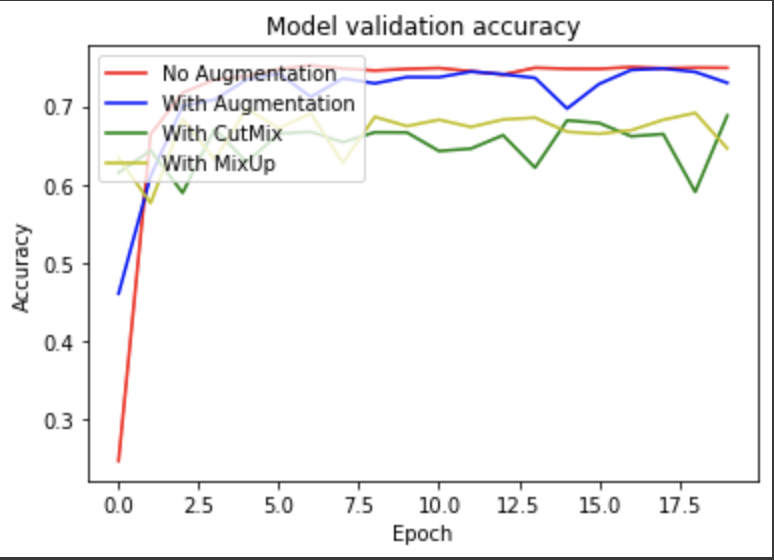

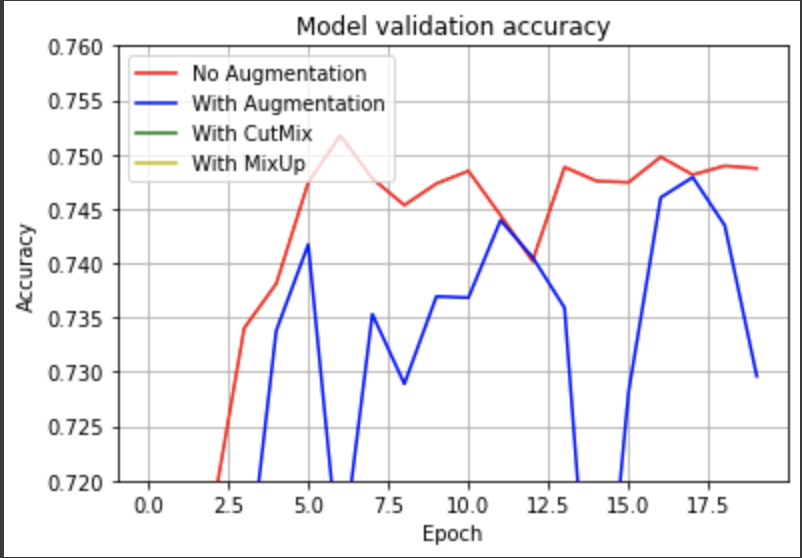

- 두번째 시도
  - 첫번째 시도 결과 no augmentation 의 accuracy 가 가장 높게 나온것을 확인 
  - 4가지 dataset 에 validation 으로 들어가는 test dataset 이 모두 one_hot 인코딩 이 된 점을 발견 
  - mixup 과 cutmix 의 경우 augmentation 적용 후 label 이 one_hot 인코딩이 된다 -> test data 에 one hot 적용 필수
  - no augmentation 과 with augmentation 의 경우 test data 에 onehot 을 적용하지 않고, sparse categorical cross entropy 를 사용해야 한다고 판단.(두번째 시도에서 사용)
  - 혹은 no_augmenation 과 with augmentation 의 train 과 test data 에 onehot 을 적용한다는 방법도 있다 
  - batch size 16 -> 32 변경
  - epoch 30 -> 15
  - random seed 고정 

> 모델을 한번만 불러오고 compile 도 한번만 하며, dataset 만 바꿔가며 train 하려고 시도했으나, test data 에서 지속적으로 사이즈 오류 발생   


> 모델을 네번 불러오고 각각 컴파일 해주며 각각 train 시도하니 해결되었다 (근본적인 이유는 또 찾지 못함...)

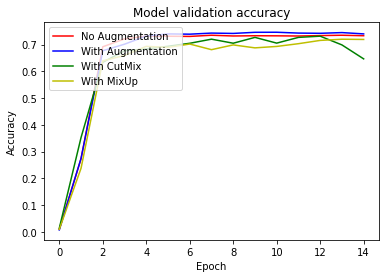

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','With CutMix','With MixUp'], loc='upper left')

plt.show()

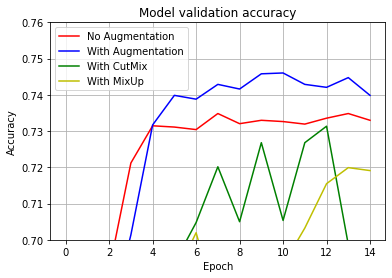

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','With CutMix','With MixUp'], loc='upper left')
plt.grid(True)
plt.ylim(0.70,0.76)

plt.show()

- 전반적인 accuracy 가 상승했다 아마도 batch size 와 random seed 가 영향을 미치지 않았을까 싶다
- with augmentation 이 no augmentation 보다 근소한 차이지만 높은 accuracy 를 보인다
- 여전히 cutmix 와 mixup 은 no augmenation 보다 accuracy 가 낮다
- 그나마 mixup 의 경우 no augmentation 과 근접한 성능을 보였다 


- 세번째 시도 
  - augmentation 이 분명 accuracy 에 도움이 되는데, 결과가 너무 근소한 차이를 보여서, augmentation 함수에 다른 random 함수들을 추가했다
  - 나머지는 동일하게 진행했다
  - with augmentaion 이 no augmentation 보다 더 좋은 성능을 내기를 바라는 마음으로 시도했다
  - 그러나 결과가 너무 처참해서 실행이 다 끝나기도 전에 중지시켰다

In [ ]:
# def augment(image,label):
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
#     image = tf.image.rot90(image)
#     image = tf.image.random_brightness(image, max_delta=0.2)
#     # image = tf.clip_by_value(image,0.1)
#     return image,label

- 네번째 시도
  - 이번에는 cutmix 와 mixup 의 성능을 높여보려는 시도를 했다
  - epoch 15 -> 50 으로 늘리고
  - 혹시나 SGD 에서 구덩이에 빠진 것은 아닐까 싶어 optimizer 를 Adam 으로 바꾸었다 
  - 결과는 너무너무 처참하다
  - 포기

In [ ]:
# tf.random.set_seed(2022)
# resnet50.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#     metrics=['accuracy'],
# )

# aug_resnet50.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#     metrics=['accuracy'],
# )

# cutmix_resnet50.compile(
#     loss='categorical_crossentropy',
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#     metrics=['accuracy'],
# )

# mixup_resnet50.compile(
#     loss='categorical_crossentropy',
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#     metrics=['accuracy'],
# )

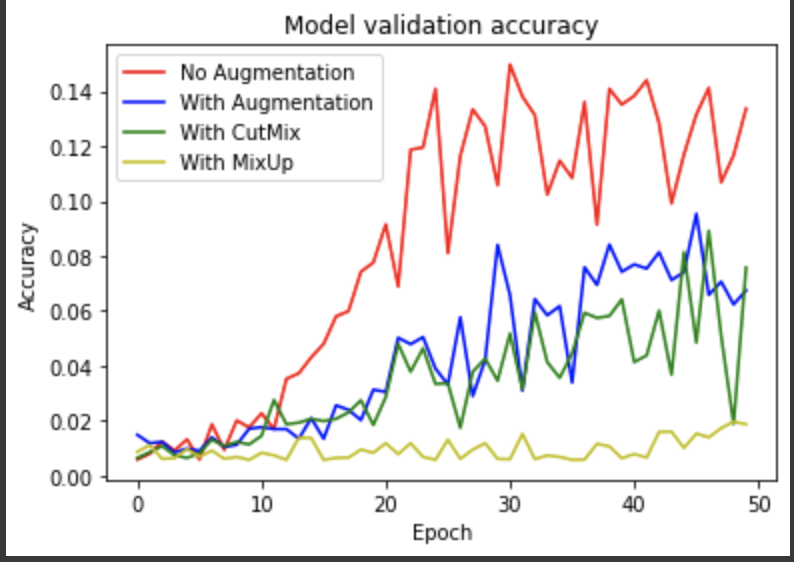

### Conclusion

---

- augmentation 이 학습에 미치는 영향에대해 알아보는 프로젝트였다
- 이론적으로는 augmentation 을 적용 할 경우에 accuracy 가 성능이 향상되어야 한다 그러나 내 결과는 영 좋지 못한 모습을 보였다
- cutmix 와 mixup 이 고급 augmentation 기술 인 점은 알겠으나, 사실 개념자체가 그렇게 와 닿지는 않는다 
  - cutmix 나 mixup 자체가 개인적인 의견으로 멀쩡한 사진을 자르고 붙혀 오히려 더 혼란스럽게 보이게 만드는 것 같은데 어떻게...도움이 된다는건지 잘 모르겠다
- 성능을 향상시키기 위해서 여러가지 시도를 해 보았는데, 끝끝내 cutmix 와 mixup 이 no augmentation 보다 좋다는 것을 증명하지 못했다 
  - augmentation 의 효과 중에 overfitting 을 방지한다는 것 도 있는데, no augmentation 과 with augmentation 의 경우 굉장히 빠른 속도로 완전한 overfitting 이 되고 있는데에 반해, 다른 두가지 경우는 확실히 overfitting 을 방지하는 것 처럼 보이는 학습 양상을 보였다. 
  - 이런 경우에는 cutmix 와 mixup augmentation 이 accuracy 가 좀 낮을 뿐 제 성능을 하고 있다고 보아야 하는 것인지 여전히 혼란스럽다 